In [ ]:
#| default_exp opt.hooks

In [ ]:
#| export
import torch
from torch import nn
from collections import OrderedDict


In [ ]:
from torch.utils.data import DataLoader
from torch import optim
from fastcore.all import *
from pathlib import Path
import torch.nn.functional as F
from fastprogress import master_bar, progress_bar
from fastprogress import progress_bar
from torchvision import models, transforms as VT, datasets
import matplotlib.pyplot as plt


In [ ]:
model = models.googlenet(weights='IMAGENET1K_V1')
tfms = VT.Compose([VT.Resize(299), VT.ToTensor()])
ds = datasets.Imagenette(root='../data', transform=tfms)

In [ ]:
dl = DataLoader(ds, batch_size=2)
xb, yb = next(iter(dl))

<matplotlib.image.AxesImage>

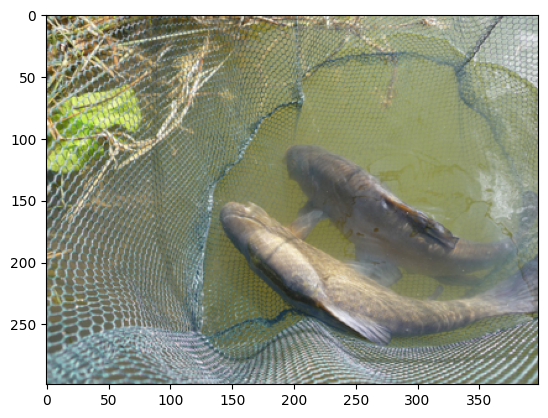

In [ ]:
plt.imshow(xb[0].permute(1, 2, 0))

In [ ]:
# | export

class CancelFitException(Exception): pass


class Hook:
    def __init__(self, module: nn.Module, fn, when='forward'):
        attr = f'register_full_{when}_hook' if when == 'backward' else f'register_{when}_hook'
        self.hook = getattr(module, attr)(self._wrap_fn(fn))

    def remove(self): self.hook.remove()

    def _wrap_fn(self, fn):
        def _inner(*args, **kwargs):
            return fn(self, *args, **kwargs)
        return _inner

    def __del__(self): self.remove()


class HooksCtx:
    def __delitem__(self, i):
        self[i].remove()
        del super()[i]

    def remove(self): raise NotImplementedError
    def __del__(self): self.remove()
    def __enter__(self): return self

    def __exit__(self, exc_type, exc_value, _):
        self.remove()
        if exc_type == CancelFitException:
            print(f'Cancelled fit at {exc_value}')
            return True


class Hooks(list, HooksCtx):
    def __init__(self, *ms, fn, when='forward'): 
        super().__init__([Hook(m, fn, when) for m in ms])

    def remove(self):
        for h in self: h.remove()


class NamedHooks(OrderedDict, HooksCtx):
    def __init__(self, mdict: dict, fn, when='forward'):
        super().__init__({k: Hook(m, fn, when) for k, m in mdict})

    def remove(self):
        for h in self.values(): h.remove()

In [ ]:
def get_shape(self, module, input, output):
    self.data = output.shape

with NamedHooks(model.named_children(), fn=get_shape) as hooks: model(xb)
for name, h in hooks.items():
    print((name, h.data))

('conv1', torch.Size([2, 64, 150, 199]))
('maxpool1', torch.Size([2, 64, 75, 99]))
('conv2', torch.Size([2, 64, 75, 99]))
('conv3', torch.Size([2, 192, 75, 99]))
('maxpool2', torch.Size([2, 192, 37, 49]))
('inception3a', torch.Size([2, 256, 37, 49]))
('inception3b', torch.Size([2, 480, 37, 49]))
('maxpool3', torch.Size([2, 480, 18, 24]))
('inception4a', torch.Size([2, 512, 18, 24]))
('inception4b', torch.Size([2, 512, 18, 24]))
('inception4c', torch.Size([2, 512, 18, 24]))
('inception4d', torch.Size([2, 528, 18, 24]))
('inception4e', torch.Size([2, 832, 18, 24]))
('maxpool4', torch.Size([2, 832, 9, 12]))
('inception5a', torch.Size([2, 832, 9, 12]))
('inception5b', torch.Size([2, 1024, 9, 12]))
('avgpool', torch.Size([2, 1024, 1, 1]))
('dropout', torch.Size([2, 1024]))
('fc', torch.Size([2, 1000]))
